In [2]:
%matplotlib inline

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import pandas as pd
import csv
from scipy import stats

# pour "jeje":
#file="/Users/jeje/Documents/Scolaire/M2/Projet_DFE/doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"
# pour "nana":
file="../doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"


In [4]:
from IPython.display import display, HTML
CSS = """.output {align-items: center;}"""
HTML('<style>{}</style>'.format(CSS))

# Déclaration des variables :

In [5]:
xmin=0
xmax=0.14
ymin=0
ymax=250
nbreaks=200

tmax=1000
ncells=1475

lambd=0.1 # paramètre de la loi de Poisson
Nt=0 # nombre de mutations avant le temps t

wt_sim=[] # Wt[x]: fitness simulée au temps t en x
wt_real=[] # Wt[x]: fitness mesurée au temps t en x 

seuil_detection_fitness=0.0005

# Tirages au sort :

In [6]:
# JJ Je crois que les deux fonctions suivantes ne serviront à rien. Mais si jamais t'en as besoin tu sais qu'elles existent :)
#def tire_exp(lambd): # inutile pour l'instant
#    u=np.random.rand()
#    res=-1/lambd*np.log(1-u)
#    return res
#
#def calcul_Nt(t,lambd): # inutile pour l'instant
#    s=0
#    res=0
#    while(s<t):
#        e=tire_exp(lambd)
#        s=s+e
#        res=res+1
#    return res

def mut_occured(lambd): # inutile pour l'instant
    x=np.random.rand()
    seuil=1 # JJ seuil est la proba de mutation ! (1 pour l'instant)
    res=x<seuil
    return res

def tire_s(s): # tire au sort un effet
    i=np.random.randint(len(s))
    return s[i]

def tire_w(wt_cur): # tire au sort une fitness initiale
    i=np.random.randint(len(wt_cur))
    return wt_cur[i]

# Simulation :

In [7]:
# JJ : utilise plutôt cette forme-là, je pense !
#def exp_sim_canal(tmax): # simule l'expérience sur unique canal
#    w=tire_w(wt_real[2]) # tirage au sort de la fitness initiale
#    w_evo=[w]
#    #ngen=0
#    for t in range(tmax):
#        if(mut_occured(lambd)): # en cas de mutation, on sélectionne un effet puis on modifie la fitness actuelle en conséquence
#            si=tire_s(s)
#            #if(si!=0):ngen+=1
#            w*=1-si
#        w_evo+=[w]
#    #print(ngen)
#    return w_evo
#
#def exp_sim(tmax,ncells): # simule tous les canaux
#    wt_sim=[]
#    wt_sim_transp=[]
#    for i in range(ncells): # pour chaque canal, on fait une simulation !
#        w_evo=exp_sim_canal(tmax)
#        wt_sim_transp+=[w_evo]
#    # on transpose pour obtenir une matrice de la bonne forme:
#    for i in range(tmax):
#        wt_cur=[]
#        for j in range(ncells):
#            wt_cur+=[wt_sim_transp[j][i]]
#        wt_sim+=[np.sort(wt_cur)]
#    return wt_sim


def exp_sim_step(wt_cur,s): # simule une étape sur tous les canaux
    wt_nouv=[]
    for w in wt_cur: # pour chaque cellule de l'expérience, de fitness w, on tire un "pseudo-effet" (éventuellement 0), et on adapte w en conséquence
        si=tire_s(s)
        wt_nouv+=[w*(1-si)]
    return wt_nouv

# Analyse des données

In [8]:
def get_y(x,wt_cur,eps): # trouve la hauteur de la barre de l'histogramme correspondant à [x-eps/2,x+eps/2]
    y=[]
    i=0
    j=0
    for x_cur in x:
        while x_cur-wt_cur[i]>eps/2 and i<len(wt_cur)-1: i+=1
        while wt_cur[j]-x_cur<eps/2 and j<len(wt_cur)-1: j+=1
        y+=[j-i]
    return y

def get_dist_s(wt_real): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=[]
    for i in range(2,len(wt_real)-1):
        for j in range(len(wt_real[i])): 
            wv=(wt_real[i])[j]
            wn=(wt_real[i+1])[j]
            if wv!=0:
                s+=[(wv-wn)/wv]
    return s

def sort_rows(w): # pour optimiser la construction de l'histogramme
    res=[]
    for row in w:
        res+=[np.sort(row)]
    return res
    
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[0] # JJ   attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open(file, newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot

# Affichage

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.legend(["Processus simulé","Processus observé"])
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    global wt_prec
    x=np.linspace(xmin,xmax,nbreaks)
    wt_sim_cur=exp_sim_step(wt_prec,s)
    y_sim=get_y(x,np.sort(wt_sim_cur),eps=(xmax-xmin)/nbreaks)
    wt_prec=wt_sim_cur
    #y_sim=get_y(x,wt_sim[frame],eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(wt_real[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,


# Lancement :
wt_real=analyse_fichier()
s=get_dist_s(wt_real)

wt_prec=[tire_w(wt_real[2]) for i in range(ncells)]

ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

In [10]:
HTML(ani.to_html5_video())

# Réécriture Pandas/Numpy

In [11]:

wt_real_df = pd.read_csv(file, 
                      sep = ";", 
                      decimal=",", 
                      usecols=range(2,1476*3+1,3), 
                      skiprows=[1,2])
wt_real_df.iloc[:5, :5]

,growth.rate,growth.rate.1,growth.rate.2,growth.rate.3,growth.rate.4
0,0.03527,0.032026,0.028119,0.029765,NaN
1,0.03527,0.032026,0.028119,0.029765,0.033812
2,0.03247,0.032026,0.026802,0.030567,0.033812
3,0.03247,0.032026,0.026802,0.030567,0.033812
4,0.03247,0.033672,0.026802,0.030567,0.033812


In [12]:
np.shape(s)

(1005906,)

<ipython-input-13-a56d8645c11a>:2: RuntimeWarning: divide by zero encountered in true_divide
  s=-np.diff(wt_real_array)/wt_real_array[:,:-1]
<ipython-input-13-a56d8645c11a>:2: RuntimeWarning: invalid value encountered in true_divide
  s=-np.diff(wt_real_array)/wt_real_array[:,:-1]


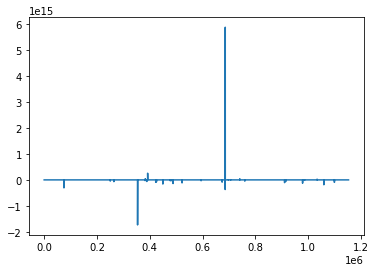

In [13]:
def get_dist_s_np(wt_real_array): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=-np.diff(wt_real_array)/wt_real_array[:,:-1]
    return s[np.isfinite(s)]

#wt_real_array = np.transpose(np.array(wt_real))
wt_real_array = wt_real_df.T.to_numpy()
s = get_dist_s_np(wt_real_array)

plt.plot(s)
plt.show()

In [14]:
exp_shape = np.shape(wt_real_array)
print(exp_shape)

(1476, 1000)


In [15]:
wt_real_array

array([[3.5269650e-02, 3.5269650e-02, 3.2470449e-02, ..., 2.8670487e-02,
        2.8670487e-02, 2.8670487e-02],
       [3.2025912e-02, 3.2025912e-02, 3.2025912e-02, ..., 1.6752654e-02,
        1.6752654e-02, 1.6752654e-02],
       [2.8119496e-02, 2.8119496e-02, 2.6801815e-02, ..., 2.5671465e-02,
        2.5671465e-02, 2.5671465e-02],
       ...,
       [2.3454689e-02, 2.3454689e-02, 2.6620318e-02, ..., 4.7900000e-05,
        4.7900000e-05, 4.7900000e-05],
       [1.8758796e-02, 1.8758796e-02, 3.0876094e-02, ..., 2.6452291e-02,
        2.6452291e-02, 2.6452291e-02],
       [          nan, 2.5567243e-02, 2.5567243e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

# Simulation réaliste

- Paramètres utilisés pour la simulation

In [16]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = 4000       # durée de l'expérience, en minutes
mut_shape = (int(exp_duration*mutation_rate*2), 1476)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)

# Paramètres de la distribution Beta fittée comme DFE dans l'article
alpha =0.0074
beta=2.4

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, 4000, 4, dtype=float)

# Distribution initiale des taux de croissances
#wt_init = wt_real_array[:,0]   # première génération de l'expérience (comprenant des taux de croissance aberrants et des NAs)
wt_init = np.array([np.median([l for l in d if not np.isnan(l)]) for d in wt_real_array[:,:10]])   # médiane des 10 premières mesures

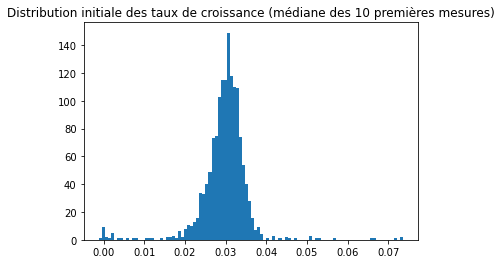

In [17]:
plt.hist(wt_init, bins=100)
plt.title("Distribution initiale des taux de croissance (médiane des 10 premières mesures)")
plt.show()

- Tirer des intervalles exponentiels entre 2 mutations pour chacun des 1476 canaux, de manière à largement dépasser les 4000 heures de l'expérience en cumulé.

(42, 1476)


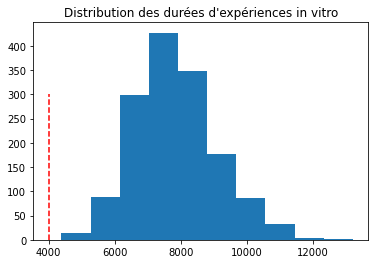

In [18]:
np.random.seed(0)    # graîne aléatoire

exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
#print(exponential_intervals)

mutation_time = np.cumsum(exponential_intervals, axis=0)  # temps d'apparition de chaque mutation, en minutes
print(np.shape(mutation_time))

plt.hist(mutation_time[-1,:])
plt.vlines(exp_duration, 0, 300, colors="red", linestyles="dashed")
plt.title("Distribution des durées d'expériences in silico")
plt.show()

# Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
assert min(mutation_time[-1,:]) > exp_duration, "Add more mutations"

- Tirer dans une DFE donnée (par exemple la Beta fittée dans l'article) un effet sur le taux de croissance pour chacune des mutations

In [19]:
np.random.seed(0)

s = np.random.beta(alpha, beta, mut_shape)   # effets relatifs des mutations sur la fitness
fitness_effects = (1 - s) * np.random.binomial(1, 1-lethal_mut_proba, mut_shape)  # rendre 1% des mutations létales
fitness_effects

array([[1.        , 1.        , 0.99705992, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.9997704 , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

$\to$ Attention aux approximations numériques : suppression de la plupart des mutations les plus faibles (ne devrait pas être un problème)

- Simuler l'évolution du taux de croissance après chaque mutation

In [20]:
cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)    # effets relatifs cumulés des mutations
wt_steps_sim = np.vstack((wt_init, cumulative_fitness_effects*wt_init))    # évolution du taux de croissance mutation par mutation

wt_steps_sim

array([[0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.02803682, ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.02803682, ..., 0.02662032, 0.02952523,
        0.02556724],
       ...,
       [0.        , 0.02617559, 0.        , ..., 0.02303736, 0.02761738,
        0.        ],
       [0.        , 0.02617559, 0.        , ..., 0.02303736, 0.02761738,
        0.        ],
       [0.        , 0.02617559, 0.        , ..., 0.02303736, 0.02761738,
        0.        ]])

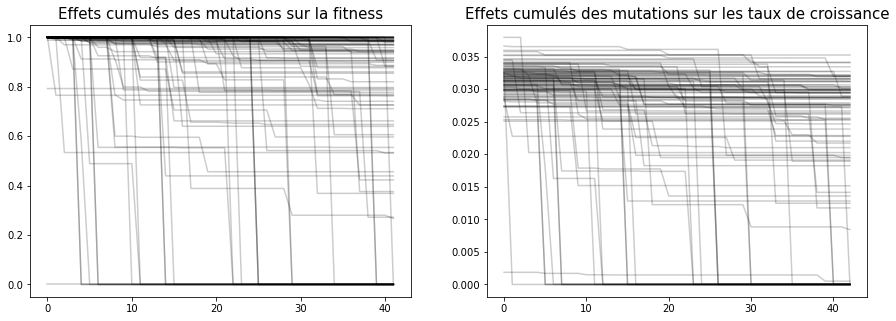

In [21]:
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(cumulative_fitness_effects[:,:100], color="black", alpha=0.2)
ax1.set_title("Effets cumulés des mutations sur la fitness",fontsize=15)
ax2.plot(wt_steps_sim[:,:100], color="black", alpha=0.2)
ax2.set_title("Effets cumulés des mutations sur les taux de croissance",fontsize=15)
plt.show()

- Combiner l'évolution du taux de croissance mutation par mutation et les intervalles entre 2 mutations pour obtenir la véritable évolution des taux de croissance

In [22]:
wt_sim = []
for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
    # Identifier après quelle mutation la mesure est faite
    cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
    # Prendre la valeur de taux de croissance associé à cette mutation
    wt_sim.append(np.piecewise(time, condlist = cond, funclist = wt_steps_sim[1:,i]))

wt_sim = np.array(wt_sim).T

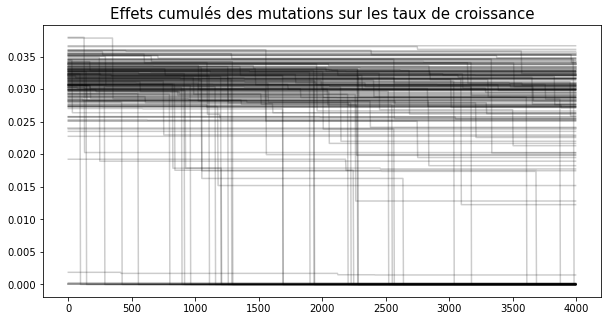

In [23]:
im, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(time, wt_sim[:,:200], color="black", alpha=0.2)
ax.set_title("Effets cumulés des mutations sur les taux de croissance",fontsize=15)
plt.show()

- La même chose condensée en 5 lignes

```exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)```

```mutation_time = np.cumsum(exponential_intervals, axis=0)```

```fitness_effects = (1 - np.random.beta(alpha, beta, mut_shape))*np.random.binomial(1, 1-lethal_mut_proba, mut_shape)```

```wt_steps_sim = np.vstack((wt_init, np.cumprod(fitness_effects, axis=0)*wt_init))```

```wt_sim = np.array([np.piecewise(time, condlist = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))]), funclist = wt_steps_sim[1:,i]) for i in range (0, np.shape(mutation_time)[1])]).T```

In [24]:
# Tentative de faire une animation:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.legend(["Processus simulé","Processus observé"])
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim=get_y(x,np.sort(wt_sim[frame]),eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(wt_real[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,


# Lancement :

ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

In [25]:
HTML(ani.to_html5_video())

$\to$ L'évolution de la distribution des taux de croissance simulés est assez proche de celle des taux observés au début, mais à la fin les deux divergent, probablement à cause de la DFE non adaptée (trop peu de mutations fortement délétères avec la Beta) et le début de la sénescence des cellules (après 40h).

# TRUCS À FAIRE :
(les remarques pour toi au sein du code sont précédées de : JJ)

* à pas faire : transformer en np.array (on le fera plus tard éventuellement ; pour l'instant, j'ai l'impression que c'est une perte de temps)
* dans la fonction exp_sim_step: là ça va poser pb, car il y aura une histoire de mémoire:
  - actuellement, on dit : "pseudo-mutation" à chaque fois !
  - mais on aimerait : n vraies mutations au bout de k/(taux de croissance) étapes (un truc comme ça, je pense...) Le soucis est que dans la version actuelle des choses, on oublie ce qui s'est passé avant !
  - il y a 2 solutions :
      - Tu décommentes le méga-commentaire juste en-dessous de simulation (~ligne 65, j'ai mis un JJ-commentaire à cet endroit) et tu adaptes. Tu obtiendras un truc de la même forme que wt_real. Décommenter la ligne 193. Inconvénient : on simule toute l'expérience avant de l'afficher donc pour tmax grand on perd du temps...
      - tu enregistres l'âge de la cellule, soit dans un tableau à part, soit tu remplaces le tableau [w_1,w_2,...] par [(w_1,a_1),(w_2,a_2)...] Inconvénient : un peu plus dur à coder (mais pas mortel non plus). Dis-moi si c'est pas clair !
* dans un premier temps : faire que tirer uniformément dans s revienne à tirer dans une beta(a,b) -> faire s=[np.random.beta(a,b) for i in range(beaucoup)]
* fonctions à toucher : get_dist_s à commenter; mut_occured: seuil à paramétrer (peut-être fonction à modifier aussi, je sais pas trop...); exp_sim,exp_sim_step,exp_sim_canal: c'est là que les modifications vont être le plus importantes: sélectionner la durée avant mutation, et stocker cette durée...
* ligne 137: si on trouve NA, on met 0 : c'était important pour garder l'alignement, nécessaire dans get_dist_s, mais bientôt ça ne servira plus à rien, donc on remplacera les NA par rien du tout :) (donc "else:..." à supprimer !)